# PYCE Loans Insurance Model

### Machine Learning Model for calculating the probability of loan default and estimating interest rates to maximize profits

### Methods used and compared: Linear Regression, Logistic Regression, Random Forest

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
import time
import warnings
warnings.filterwarnings("ignore")

In [3]:
results = pd.read_csv('Result_Stage1_25.csv').drop('id', axis = 1)
results

,own,competing1,competing3,borrowertype,accepted,default,profit
0,NaN,0.405000,0.236840,0,0,0,NaN
1,NaN,0.092714,0.152445,2,0,1,NaN
2,NaN,0.060536,NaN,0,0,0,NaN
3,0.040365,0.159082,0.004469,0,0,0,NaN
4,NaN,0.944560,0.297304,3,0,0,NaN
...,...,...,...,...,...,...,...
99995,0.060634,0.088147,0.165407,0,1,0,606.34381
99996,NaN,0.234034,NaN,0,0,0,NaN
99997,NaN,0.193021,0.178011,0,0,0,NaN
99998,NaN,0.300000,0.125500,0,0,0,NaN


In [4]:
results.describe().round(3)

,own,competing1,competing3,borrowertype,accepted,default,profit
count,20908.000,93772.000,73433.000,100000.00,100000.000,100000.000,12005.000
mean,0.059,0.262,0.253,0.60,0.120,0.198,-101.403
std,0.017,0.211,0.167,1.02,0.325,0.398,2658.640
min,0.040,0.000,0.000,0.00,0.000,0.000,-10000.000
25%,0.043,0.103,0.142,0.00,0.000,0.000,433.464
50%,0.055,0.224,0.214,0.00,0.000,0.000,562.741
75%,0.073,0.383,0.316,1.00,0.000,0.000,738.773
max,0.093,1.000,1.000,3.00,1.000,1.000,926.195


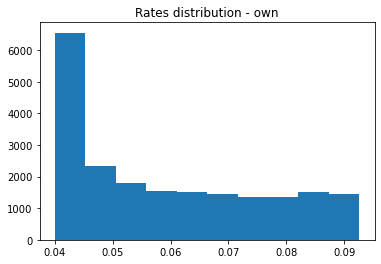

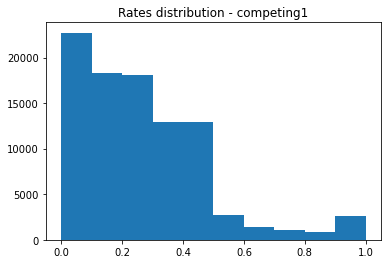

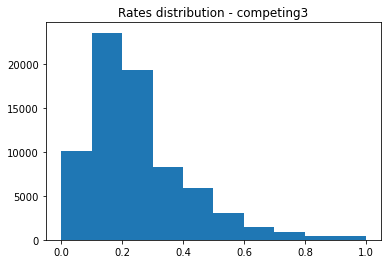

In [5]:
plt.hist(results.own)
plt.title('Rates distribution - own')
plt.show()

plt.hist(results.competing1)
plt.title('Rates distribution - competing1')
plt.show()

plt.hist(results.competing3)
plt.title('Rates distribution - competing3')
plt.show()


## Functions

- Calculate our profit based on the competitors' interest rate and on the borrower preferences. We can use it to simulate different strategies
- Calculate competing1 and competing3 performance

In [6]:
def calculate_profit(row):
    if np.isnan(row.rate):
        return np.nan
    elif np.isnan(row.competing1) and np.isnan(row.competing3):
        return np.nan
    elif np.isnan(row.competing1):
        if row.borrowertype != 3 and row.rate < row.competing3:
            return aux(row.default, row.rate)
        elif row.borrowertype == 3 and row.competing3 - row.rate > 0.0200001:
            return aux(row.default, row.rate)
        elif row.borrowertype == 2 and row.rate - row.competing3 < 0.01999999:
            return aux(row.default, row.rate)
        else:
            return np.nan
    elif np.isnan(row.competing3):
        if row.borrowertype != 1 and row.rate < row.competing1:
            return aux(row.default, row.rate)
        elif row.borrowertype == 1 and row.competing1 - row.rate > 0.0200001:
            return aux(row.default, row.rate)
        elif row.borrowertype == 2 and row.rate - row.competing1 < 0.01999999:
            return aux(row.default, row.rate)
        else:
            return np.nan
    else: #all bid
        if row.borrowertype == 0 and row.rate < row.competing1 and row.rate < row.competing3:
            return aux(row.default, row.rate)
        elif row.borrowertype == 1 and row.rate < row.competing3 and row.competing1 - row.rate > 0.0200001:
            return aux(row.default, row.rate)
        elif row.borrowertype == 2 and row.rate - row.competing1 < 0.0199999 and row.rate - row.competing3 < 0.01999999:
            return aux(row.default, row.rate)
        elif row.borrowertype == 3 and row.rate < row.competing1 and row.competing3 - row.rate > 0.0200001:
            return aux(row.default, row.rate)
        else:
            return np.nan

In [7]:
def aux(default, competing1):
    if default:
        return -10000
    return 10000*competing1

def profit1(row):
    
    # No bid
    if np.isnan(row.competing1):
        return np.nan
    
    #Only bid
    elif np.isnan(row.own) and np.isnan(row.competing3):
        return aux(row.default, row.competing1)
    
    #Competes only with competing3
    elif np.isnan(row.own):
        if row.borrowertype != 3 and row.competing1 < row.competing3:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 3 and row.competing3 - row.competing1 > 0.0200001:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 1 and row.competing1 - row.competing3 < 0.01999999:
            return aux(row.default, row.competing1)
        else:
            return np.nan
        
    #Competes only with own    
    elif np.isnan(row.competing3):
        if row.borrowertype != 2 and row.competing1 < row.own:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 2 and row.own - row.competing1 > 0.0200001:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 1 and row.competing1 - row.own < 0.01999999:
            return aux(row.default, row.competing1)
        else:
            return np.nan
        
    #All companies bid
    else: 
        if row.borrowertype == 0 and row.competing1 < row.own and row.competing1 < row.competing3:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 1 and row.competing1 - row.own < 0.0199999 and row.competing1 - row.competing3 < 0.01999999:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 2 and row.competing1 < row.competing3 and row.own - row.competing1 > 0.0200001:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 3 and row.competing1 < row.own and row.competing3 - row.competing1 > 0.0200001:
            return aux(row.default, row.competing1)
        else:
            return np.nan
        
        
        
def profit3(row):
    if np.isnan(row.profit) and np.isnan(row.profit1) and not np.isnan(row.competing3):
        return aux(row.default, row.competing3)
    return np.nan

In [8]:
start_time = time.time()

results['profit1'] = results.apply(profit1, axis = 1)
results['profit3'] = results.apply(profit3, axis = 1)

print("--- {:.2f} seconds ---".format(time.time() - start_time))
results

--- 14.65 seconds ---


,own,competing1,competing3,borrowertype,accepted,default,profit,profit1,profit3
0,NaN,0.405000,0.236840,0,0,0,NaN,NaN,2368.398900
1,NaN,0.092714,0.152445,2,0,1,NaN,-10000.00000,NaN
2,NaN,0.060536,NaN,0,0,0,NaN,605.36075,NaN
3,0.040365,0.159082,0.004469,0,0,0,NaN,NaN,44.694184
4,NaN,0.944560,0.297304,3,0,0,NaN,NaN,2973.042700
...,...,...,...,...,...,...,...,...,...
99995,0.060634,0.088147,0.165407,0,1,0,606.34381,NaN,NaN
99996,NaN,0.234034,NaN,0,0,0,NaN,2340.34240,NaN
99997,NaN,0.193021,0.178011,0,0,0,NaN,NaN,1780.105100
99998,NaN,0.300000,0.125500,0,0,0,NaN,NaN,1254.999900


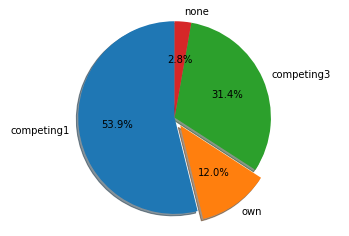

In [9]:
labels = 'competing1','own', 'competing3', 'none'
a = results[results.profit.notnull()].shape[0]
b = results[results.profit1.notnull()].shape[0]
c = results[results.profit3.notnull()].shape[0]
d = results.shape[0] - (a+b+c)
sizes = [b, a, c, d]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [10]:
print('We won {:.1f}% of our bids'.format(a/results[results.own.notnull()].shape[0]*100))
print('Competing1 won {:.1f}% of their bids'.format(b/results[results.competing1.notnull()].shape[0]*100))
print('Competing3 won {:.1f}% of their bids'.format(c/results[results.competing3.notnull()].shape[0]*100))

We won 57.4% of our bids
Competing1 won 57.4% of their bids
Competing3 won 42.7% of their bids


In [11]:
#Join probabilities
sr_prob = pd.read_csv('updated_probs_stage1.csv', index_col = 0)
final = pd.concat([sr_prob, results], axis = 1)
final

,probability,own,competing1,competing3,borrowertype,accepted,default,profit,profit1,profit3
0,0.291848,NaN,0.405000,0.236840,0,0,0,NaN,NaN,2368.398900
1,0.175391,NaN,0.092714,0.152445,2,0,1,NaN,-10000.00000,NaN
2,0.079274,NaN,0.060536,NaN,0,0,0,NaN,605.36075,NaN
3,0.014177,0.040365,0.159082,0.004469,0,0,0,NaN,NaN,44.694184
4,0.239929,NaN,0.944560,0.297304,3,0,0,NaN,NaN,2973.042700
...,...,...,...,...,...,...,...,...,...,...
99995,0.059121,0.060634,0.088147,0.165407,0,1,0,606.34381,NaN,NaN
99996,0.400499,NaN,0.234034,NaN,0,0,0,NaN,2340.34240,NaN
99997,0.238915,NaN,0.193021,0.178011,0,0,0,NaN,NaN,1780.105100
99998,0.173570,NaN,0.300000,0.125500,0,0,0,NaN,NaN,1254.999900


In [14]:
def total_profit(cut, floor):
    x = final.copy()
    x['rate'] = np.where(x['probability'] < cut, x['probability']/(1-x['probability']) + floor, np.nan)
    x.loc[x["rate"] > 1, "rate"] = 1
    x['profit'] = x.apply(calculate_profit, axis=1)
    profit = x.profit.sum()
    loans = x[x['rate'].notnull()].shape[0]
    wins = x[x['profit'].notnull()].shape[0]
    defaults = x[x['profit'].notnull()][x['default'] == 1].shape[0]
    return profit, loans, wins, defaults

In [15]:
print(total_profit(0.05, 0.04))

(1465415.2445373558, 13702, 4376, 156)


# Scenarios simulation

### After optimizing the Random Forest parameters, we tested different cut (probability above which we wouldn't give loans) and floor (minimum interest rate, considering a 0% probability of default) points.

- We simulated the new interest rates in the market, based on the competitors' rates and borrower preferences.



In [18]:
%%time
#df_profit = pd.DataFrame(columns = ['cut', 'floor', 'profit', 'loans', 'wins'])
'''
d = []
for i in range(1, 51):
    #print(i)
    for j in range(0, 101):
        print(i, j)
        cut = i*0.01
        floor = j*0.005
        profit, loans, wins, defaults = total_profit(cut, floor)
        d_aux = {}
        d_aux['cut'] = cut
        d_aux['floor'] = floor
        d_aux['profit'] = profit
        d_aux['loans'] = loans
        d_aux['wins'] = wins
        d_aux['defaults'] = defaults
        d.append(d_aux)
        #df_profit.loc[-1] = [cut, floor, profit, loans, wins]
        #df_profit.index = df_profit.index + 1  # shifting index
        #df_profit = df_profit.sort_index()
        
df_profit = pd.DataFrame.from_dict(d)

1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
1 100
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
2 50
2 51
2 52
2 53
2 54
2 55
2 56
2 57
2 58
2 59
2 60
2 61
2 62
2 63
2 64
2 65
2 66
2 67
2 68
2 69
2 70
2 71
2 72
2 73
2 74
2 75
2 76
2 77
2 78
2 79
2 80
2 81
2 82
2 83
2 84
2 85
2 86
2 87
2 88
2 89
2 90
2 91
2 92
2 93
2 94
2 95
2 96
2 97
2 98
2 99
2 100
3 0
3 1


16 27
16 28
16 29
16 30
16 31
16 32
16 33
16 34
16 35
16 36
16 37
16 38
16 39
16 40
16 41
16 42
16 43
16 44
16 45
16 46
16 47
16 48
16 49
16 50
16 51
16 52
16 53
16 54
16 55
16 56
16 57
16 58
16 59
16 60
16 61
16 62
16 63
16 64
16 65
16 66
16 67
16 68
16 69
16 70
16 71
16 72
16 73
16 74
16 75
16 76
16 77
16 78
16 79
16 80
16 81
16 82
16 83
16 84
16 85
16 86
16 87
16 88
16 89
16 90
16 91
16 92
16 93
16 94
16 95
16 96
16 97
16 98
16 99
16 100
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
17 11
17 12
17 13
17 14
17 15
17 16
17 17
17 18
17 19
17 20
17 21
17 22
17 23
17 24
17 25
17 26
17 27
17 28
17 29
17 30
17 31
17 32
17 33
17 34
17 35
17 36
17 37
17 38
17 39
17 40
17 41
17 42
17 43
17 44
17 45
17 46
17 47
17 48
17 49
17 50
17 51
17 52
17 53
17 54
17 55
17 56
17 57
17 58
17 59
17 60
17 61
17 62
17 63
17 64
17 65
17 66
17 67
17 68
17 69
17 70
17 71
17 72
17 73
17 74
17 75
17 76
17 77
17 78
17 79
17 80
17 81
17 82
17 83
17 84
17 85
17 86
17 87
17 88
17 89
17 90
17 91
17 92
17 93
1

29 99
29 100
30 0
30 1
30 2
30 3
30 4
30 5
30 6
30 7
30 8
30 9
30 10
30 11
30 12
30 13
30 14
30 15
30 16
30 17
30 18
30 19
30 20
30 21
30 22
30 23
30 24
30 25
30 26
30 27
30 28
30 29
30 30
30 31
30 32
30 33
30 34
30 35
30 36
30 37
30 38
30 39
30 40
30 41
30 42
30 43
30 44
30 45
30 46
30 47
30 48
30 49
30 50
30 51
30 52
30 53
30 54
30 55
30 56
30 57
30 58
30 59
30 60
30 61
30 62
30 63
30 64
30 65
30 66
30 67
30 68
30 69
30 70
30 71
30 72
30 73
30 74
30 75
30 76
30 77
30 78
30 79
30 80
30 81
30 82
30 83
30 84
30 85
30 86
30 87
30 88
30 89
30 90
30 91
30 92
30 93
30 94
30 95
30 96
30 97
30 98
30 99
30 100
31 0
31 1
31 2
31 3
31 4
31 5
31 6
31 7
31 8
31 9
31 10
31 11
31 12
31 13
31 14
31 15
31 16
31 17
31 18
31 19
31 20
31 21
31 22
31 23
31 24
31 25
31 26
31 27
31 28
31 29
31 30
31 31
31 32
31 33
31 34
31 35
31 36
31 37
31 38
31 39
31 40
31 41
31 42
31 43
31 44
31 45
31 46
31 47
31 48
31 49
31 50
31 51
31 52
31 53
31 54
31 55
31 56
31 57
31 58
31 59
31 60
31 61
31 62
31 63
31 64
31 65
31 6

43 72
43 73
43 74
43 75
43 76
43 77
43 78
43 79
43 80
43 81
43 82
43 83
43 84
43 85
43 86
43 87
43 88
43 89
43 90
43 91
43 92
43 93
43 94
43 95
43 96
43 97
43 98
43 99
43 100
44 0
44 1
44 2
44 3
44 4
44 5
44 6
44 7
44 8
44 9
44 10
44 11
44 12
44 13
44 14
44 15
44 16
44 17
44 18
44 19
44 20
44 21
44 22
44 23
44 24
44 25
44 26
44 27
44 28
44 29
44 30
44 31
44 32
44 33
44 34
44 35
44 36
44 37
44 38
44 39
44 40
44 41
44 42
44 43
44 44
44 45
44 46
44 47
44 48
44 49
44 50
44 51
44 52
44 53
44 54
44 55
44 56
44 57
44 58
44 59
44 60
44 61
44 62
44 63
44 64
44 65
44 66
44 67
44 68
44 69
44 70
44 71
44 72
44 73
44 74
44 75
44 76
44 77
44 78
44 79
44 80
44 81
44 82
44 83
44 84
44 85
44 86
44 87
44 88
44 89
44 90
44 91
44 92
44 93
44 94
44 95
44 96
44 97
44 98
44 99
44 100
45 0
45 1
45 2
45 3
45 4
45 5
45 6
45 7
45 8
45 9
45 10
45 11
45 12
45 13
45 14
45 15
45 16
45 17
45 18
45 19
45 20
45 21
45 22
45 23
45 24
45 25
45 26
45 27
45 28
45 29
45 30
45 31
45 32
45 33
45 34
45 35
45 36
45 37
45 38
45 3

In [25]:
#df_profit.to_csv('profit_simulation.csv')

In [76]:
%%time

df_profit = pd.read_csv('profit_simulation.csv', index_col=0)
df_profit['acceptance'] = df_profit['wins']/df_profit['loans']
df_profit['default_rate'] = df_profit.defaults / df_profit.wins
df_profit.sort_values('profit', ascending = False)


Wall time: 27 ms


,cut,floor,profit,loans,wins,defaults,acceptance,default_rate
4871,0.49,0.115,8.007765e+06,98768,10931,2134,0.110673,0.195225
4972,0.50,0.115,7.997765e+06,99061,10932,2135,0.110356,0.195298
4770,0.48,0.115,7.997765e+06,98441,10930,2134,0.111031,0.195242
4669,0.47,0.115,7.957765e+06,97892,10926,2134,0.111613,0.195314
4568,0.46,0.115,7.911346e+06,97377,10893,2120,0.111864,0.194620
...,...,...,...,...,...,...,...,...
4444,0.45,0.000,-5.520959e+06,96906,42972,6233,0.443440,0.145048
4545,0.46,0.000,-5.526587e+06,97377,43013,6252,0.441716,0.145351
4848,0.49,0.000,-5.532491e+06,98768,43116,6301,0.436538,0.146141
3333,0.34,0.000,-5.547026e+06,85495,41631,5716,0.486941,0.137302


# Data visualization

- Graph 1: we can see that the greates profits and losses occur on the highest cut points. This show a great sensitivity on the floor point chosen, that will be further assessed on the second graph.
- Graph 2: now, we can see that low floor points lead to the biggest losses (hence, when combined with high cut points), and the optimal floor point resides between 10 and 13%

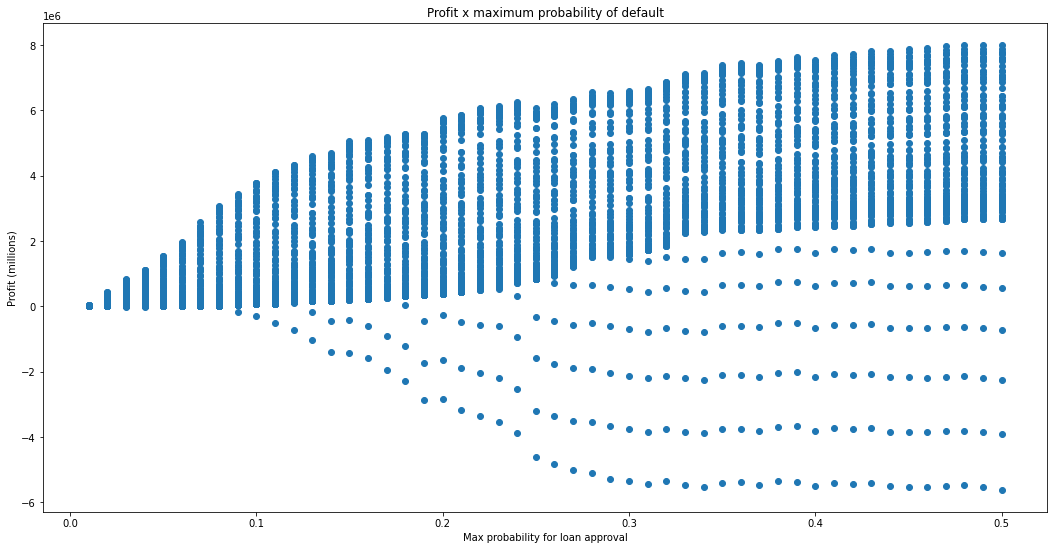

In [38]:
plt.figure(figsize=(18,9))
plt.scatter(df_profit['cut'], df_profit['profit'])
plt.title('Profit x maximum probability of default')
plt.ylabel('Profit (millions)')
plt.xlabel('Max probability for loan approval')
plt.show()

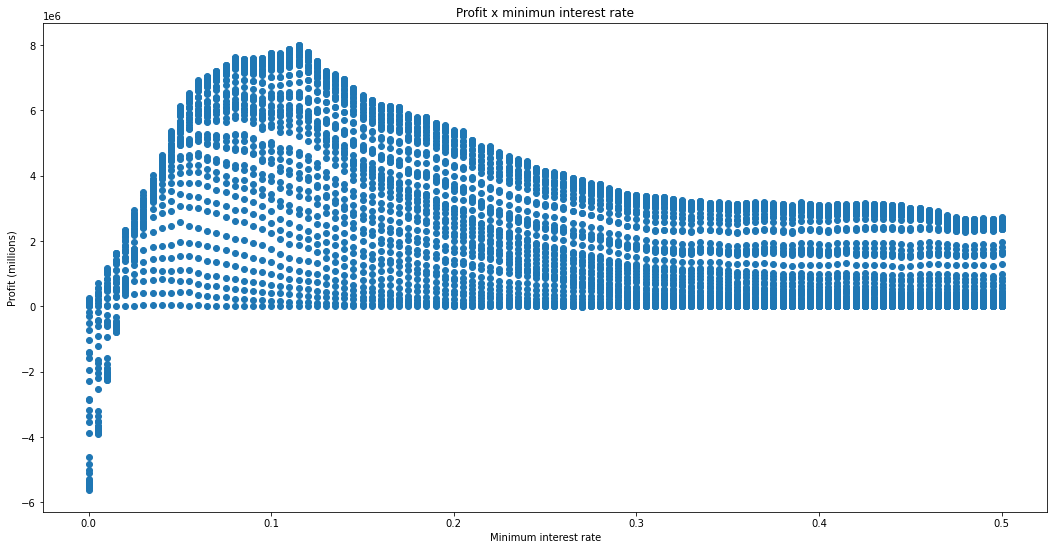

In [39]:
plt.figure(figsize=(18,9))
plt.scatter(df_profit['floor'], df_profit['profit'])
plt.title('Profit x minimun interest rate')
plt.ylabel('Profit (millions)')
plt.xlabel('Minimum interest rate')
plt.show()

In [60]:
df_profit[df_profit['profit']>0].sort_values('acceptance', ascending = False).head(10)

,cut,floor,profit,loans,wins,defaults,acceptance,default_rate
101,0.02,0.000,132225.317031,3205,2085,18,0.650546,0.008633
1,0.01,0.005,2001.004000,253,163,2,0.644269,0.012270
707,0.08,0.000,16466.351165,23520,14916,683,0.634184,0.045790
1112,0.12,0.005,100975.792664,33932,21202,1449,0.624838,0.068343
606,0.07,0.000,245493.125180,20208,12603,488,0.623664,0.038721
1011,0.11,0.005,233307.674220,31269,19408,1224,0.620679,0.063067
505,0.06,0.000,177378.654827,16352,10091,331,0.617111,0.032802
910,0.10,0.005,376323.972712,28478,17406,993,0.611209,0.057049
2,0.01,0.010,8394.526076,253,154,2,0.608696,0.012987
404,0.05,0.000,59710.265054,13702,8274,242,0.603853,0.029248


# Are the default rate or the acceptance rate good metrics for profit??

- According to the simulation, no. The most profitable scenarios scored average in both metrics, but all give loans to virtually everybody with high interest rates

In [71]:
x = df_profit.sort_values('default_rate').reset_index()
print('The most profitable scenario is the {}th smallest default rate from {} scenarios'.format(x.profit.idxmax(), x.shape[0]))

The most profitable scenario is the 2462th smallest default rate from 5050 scenarios


In [72]:
x = df_profit.sort_values('acceptance', ascending = False).reset_index()
print('The most profitable scenario is the {}th biggest acceptance rate from {} scenarios'.format(x.profit.idxmax(), x.shape[0]))

The most profitable scenario is the 1161th biggest acceptance rate from 5050 scenarios


In [48]:
x = final.copy()
x['rate'] = np.where(x['probability'] < 0.49, x['probability']/(1-x['probability']) + 0.115, np.nan)
x.loc[x["rate"] > 1, "rate"] = 1
x['profit'] = x.apply(calculate_profit, axis=1)
x

,probability,own,competing1,competing3,borrowertype,accepted,default,profit,profit1,profit3,rate
0,0.291848,NaN,0.405000,0.236840,0,0,0,NaN,NaN,2368.398900,0.527125
1,0.175391,NaN,0.092714,0.152445,2,0,1,NaN,-10000.00000,NaN,0.327695
2,0.079274,NaN,0.060536,NaN,0,0,0,NaN,605.36075,NaN,0.201099
3,0.014177,0.040365,0.159082,0.004469,0,0,0,NaN,NaN,44.694184,0.129381
4,0.239929,NaN,0.944560,0.297304,3,0,0,NaN,NaN,2973.042700,0.430667
...,...,...,...,...,...,...,...,...,...,...,...
99995,0.059121,0.060634,0.088147,0.165407,0,1,0,NaN,NaN,NaN,0.177836
99996,0.400499,NaN,0.234034,NaN,0,0,0,NaN,2340.34240,NaN,0.783055
99997,0.238915,NaN,0.193021,0.178011,0,0,0,NaN,NaN,1780.105100,0.428913
99998,0.173570,NaN,0.300000,0.125500,0,0,0,NaN,NaN,1254.999900,0.325024


In [54]:
x[x.profit.notnull()]

,probability,own,competing1,competing3,borrowertype,accepted,default,profit,profit1,profit3,rate
16,0.170439,NaN,0.400000,NaN,1,0,0,3204.562661,4000.0001,NaN,0.320456
31,0.236664,NaN,0.491000,0.428951,2,0,0,4250.384299,NaN,4289.5141,0.425038
40,0.279093,NaN,1.000000,NaN,0,0,0,5021.407886,10000.0000,NaN,0.502141
49,0.058802,0.076754,0.400000,0.176600,2,1,0,1774.760616,NaN,NaN,0.177476
54,0.154562,NaN,0.400000,NaN,0,0,0,2978.190460,4000.0001,NaN,0.297819
...,...,...,...,...,...,...,...,...,...,...,...
99952,0.293182,NaN,NaN,0.551784,0,0,1,-10000.000000,NaN,-10000.0000,0.529792
99960,0.214524,NaN,0.436000,NaN,3,0,0,3881.126151,4359.9999,NaN,0.388113
99986,0.242452,NaN,1.000000,NaN,0,0,0,4350.487669,10000.0000,NaN,0.435049
99988,0.098249,NaN,0.272148,NaN,3,0,0,2239.537102,2721.4816,NaN,0.223954


# Conclusion

## We have 2 possible outcomes:

1. We choose the best scenario. This would maximize profit ONLY IF the competitors' strategies don't change much, because we rely on this competitive scenario
2. We abdicate on maximizing profit to simply have profit. Choose a profitable scenario with 

In [80]:
x = df_profit.sort_values('profit', ascending = False).head(100).reset_index()
x.sort_values('acceptance', ascending=False)


,index,cut,floor,profit,loans,wins,defaults,acceptance,default_rate
95,3753,0.38,0.080,7.434132e+06,90569,16561,2826,0.182855,0.170642
75,3854,0.39,0.080,7.506929e+06,91660,16668,2866,0.181846,0.171946
70,4056,0.41,0.080,7.517941e+06,93215,16803,2923,0.180261,0.173957
67,4157,0.42,0.080,7.521390e+06,93719,16833,2936,0.179611,0.174419
49,4258,0.43,0.080,7.595138e+06,94716,16915,2969,0.178587,0.175525
...,...,...,...,...,...,...,...,...,...
15,4973,0.50,0.120,7.786126e+06,99061,10250,2031,0.103472,0.198146
89,4671,0.47,0.125,7.462806e+06,97892,9628,1947,0.098353,0.202223
77,4772,0.48,0.125,7.502806e+06,98441,9632,1947,0.097845,0.202139
71,4873,0.49,0.125,7.512806e+06,98768,9633,1947,0.097532,0.202118
